# California Housing Price Prediction (No-Terminal Notebook)

Run **Cell → Run All**.

In [7]:

# 1) Imports & setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

import joblib

OUT_DIR = Path("models")
OUT_DIR.mkdir(parents=True, exist_ok=True)
MODEL_PATH = OUT_DIR / "rf_cali_housing.joblib"

print("Notebook working directory:", Path.cwd())
print("Model will be saved to:", MODEL_PATH)


Notebook working directory: /Users/mac
Model will be saved to: models/rf_cali_housing.joblib


In [8]:

# 2) Load dataset
data = fetch_california_housing(as_frame=True)
df = data.frame.copy()
X = df.drop(columns=["MedHouseVal"])
y = df["MedHouseVal"]

print("Features:", list(X.columns))
print("Shapes -> X:", X.shape, "| y:", y.shape)
X.head()


Features: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
Shapes -> X: (20640, 8) | y: (20640,)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [9]:

# 3) Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train size:", X_train.shape, "Test size:", X_test.shape)


Train size: (16512, 8) Test size: (4128, 8)


In [10]:

# 4) Pipeline: scale numeric + RandomForest
numeric_features = list(X.columns)
pre = ColumnTransformer([("num", StandardScaler(), numeric_features)], remainder="drop")
model = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1)
pipe = Pipeline([("pre", pre), ("model", model)])

pipe.fit(X_train, y_train)
joblib.dump(pipe, MODEL_PATH)
print("✅ Trained and saved model to:", MODEL_PATH)


✅ Trained and saved model to: models/rf_cali_housing.joblib


In [14]:
# 5) Evaluate  (compatible with all sklearn versions)
preds = pipe.predict(X_test)

mae = mean_absolute_error(y_test, preds)
mse = mean_squared_error(y_test, preds)   # MSE
rmse = mse ** 0.5                         # RMSE = sqrt(MSE)
r2 = r2_score(y_test, preds)

print(f"MAE : {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R^2 : {r2:.3f}")


MAE : 0.326
RMSE: 0.503
R^2 : 0.807


Top features:
       feature  importance
0      MedInc    0.525739
5    AveOccup    0.138087
7   Longitude    0.088589
6    Latitude    0.088516
1    HouseAge    0.054228
2    AveRooms    0.044642
4  Population    0.030484
3   AveBedrms    0.029715


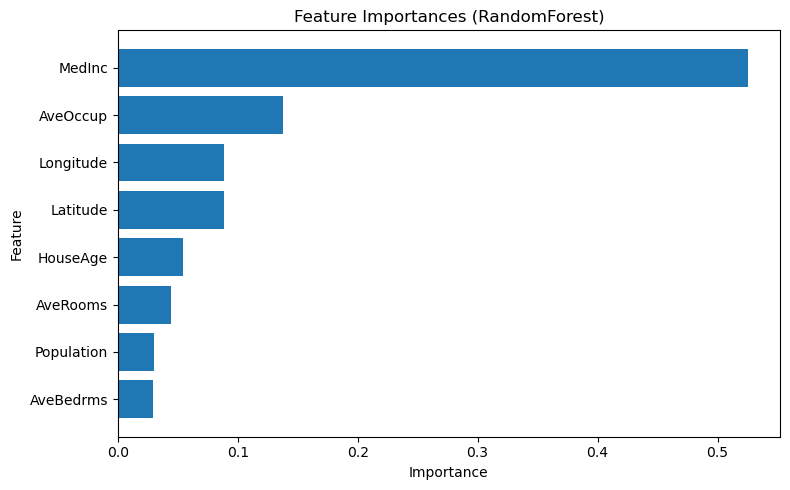

In [15]:

# 6) Feature importances
rf = pipe.named_steps["model"]
importances = rf.feature_importances_
import pandas as pd
fi = pd.DataFrame({"feature": numeric_features, "importance": importances}).sort_values("importance", ascending=False)

print("Top features:\n", fi.head(10))

plt.figure(figsize=(8,5))
plt.barh(fi["feature"], fi["importance"])
plt.gca().invert_yaxis()
plt.title("Feature Importances (RandomForest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [17]:
# 7) Quick prediction helper (fixed for ColumnTransformer with named columns)
import numpy as np
import pandas as pd
import joblib

# Feature order reference (used during training):
# ['MedInc','HouseAge','AveRooms','AveBedrms','Population','AveOccup','Latitude','Longitude']

def predict_price(medinc, house_age, ave_rooms, ave_bedrms, population, ave_occup, latitude, longitude):
    model = joblib.load(MODEL_PATH)

    # Try to read the exact feature names from the saved pipeline
    try:
        feature_names = list(model.named_steps["pre"].transformers_[0][2])
    except Exception:
        # Fallback to the known order if not available
        feature_names = ['MedInc','HouseAge','AveRooms','AveBedrms','Population','AveOccup','Latitude','Longitude']

    row = [[medinc, house_age, ave_rooms, ave_bedrms, population, ave_occup, latitude, longitude]]
    df = pd.DataFrame(row, columns=feature_names)  # <-- DataFrame with names
    pred_100k = model.predict(df)[0]               # model was trained with target in $100k
    return pred_100k * 100000

# Example
example = predict_price(5.0, 25, 6.0, 1.0, 1000, 3.0, 34.2, -118.3)
print(f"Example predicted price: ${example:,.0f}")


Example predicted price: $228,562
